In [1]:
# Step 1: Install needed packages (optional)
!pip install wordcloud

# Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datetime import datetime

# Display settings
pd.set_option('display.max_columns', 50)


In [2]:
from google.colab import files
uploaded = files.upload()  # Upload netflix_titles.csv


Saving netflix_titles.csv to netflix_titles.csv


In [3]:
df = pd.read_csv('netflix_titles.csv')
df.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [4]:
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

df['director'].fillna('Unknown', inplace=True)
df['cast'].fillna('Unknown', inplace=True)
df['country'].fillna('Unknown', inplace=True)
df['rating'].fillna('Not Rated', inplace=True)

def parse_duration(x):
    if pd.isna(x):
        return np.nan, np.nan
    s = str(x)
    if "min" in s:
        return int(s.split()[0]), "min"
    if "Season" in s:
        return int(s.split()[0]), "season"
    return np.nan, None

df[['duration_value', 'duration_type']] = df['duration'].apply(lambda x: pd.Series(parse_duration(x)))

df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month


/tmp/ipython-input-3539016305.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['director'].fillna('Unknown', inplace=True)
/tmp/ipython-input-3539016305.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

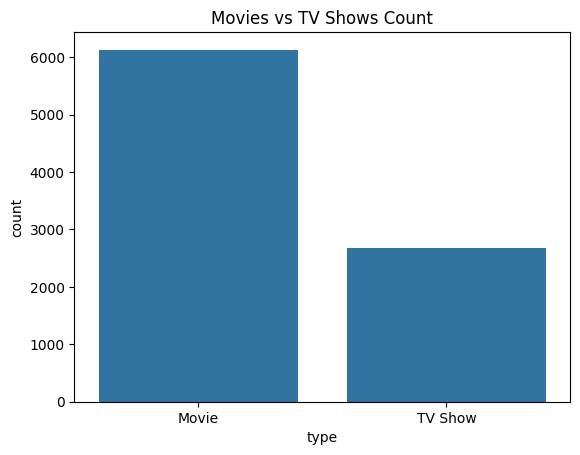

In [5]:
# Movies vs TV Shows
sns.countplot(x=df['type'])
plt.title("Movies vs TV Shows Count")
plt.show()


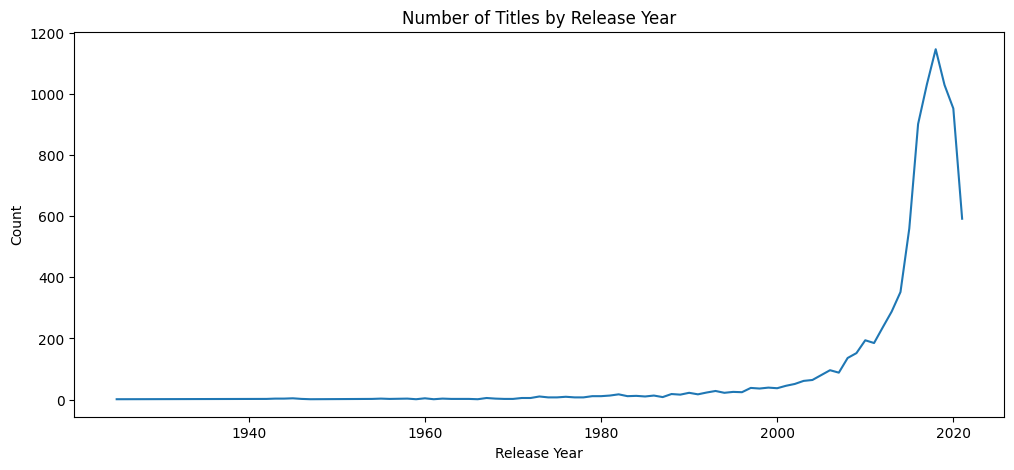

In [6]:
# Titles by Release Year
df['release_year'].value_counts().sort_index().plot(figsize=(12,5))
plt.title("Number of Titles by Release Year")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.show()


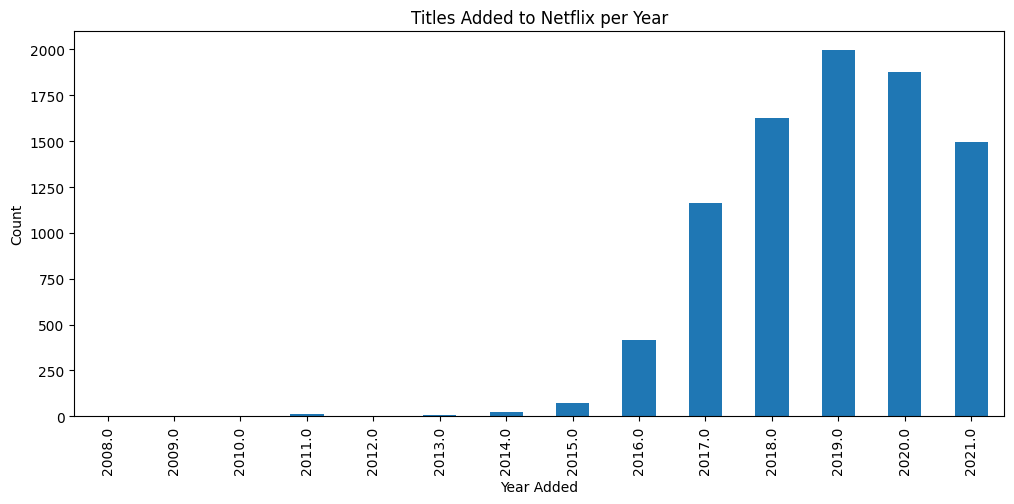

In [7]:
# Titles added per year
df['year_added'].value_counts().sort_index().plot(kind='bar', figsize=(12,5))
plt.title("Titles Added to Netflix per Year")
plt.xlabel("Year Added")
plt.ylabel("Count")
plt.show()


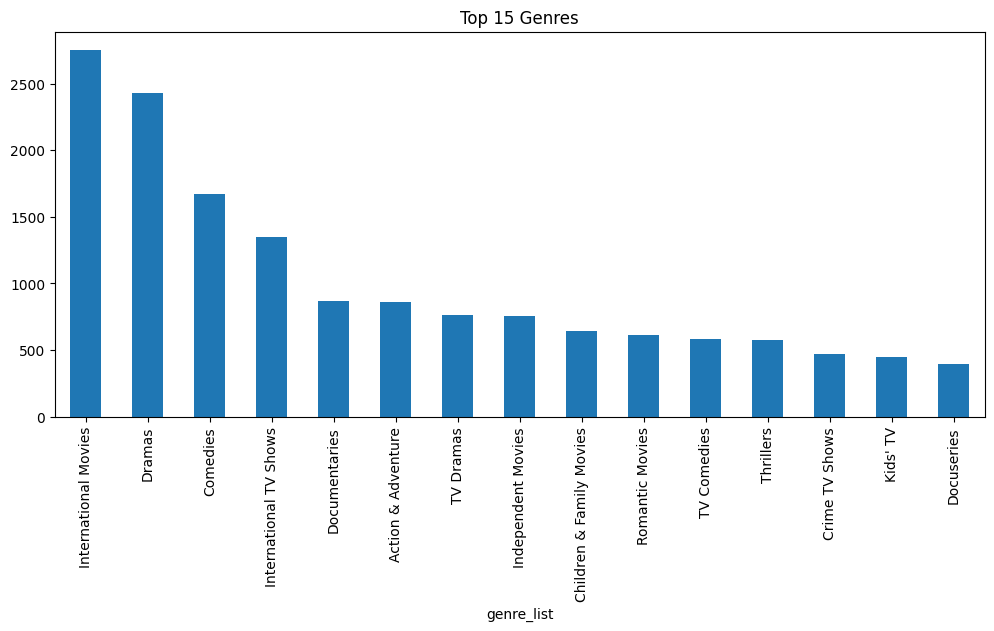

In [8]:
# Top Genres
df['genre_list'] = df['listed_in'].apply(lambda x: [g.strip() for g in x.split(',')])
genres = df['genre_list'].explode()
genres.value_counts().head(15).plot(kind='bar', figsize=(12,5))
plt.title("Top 15 Genres")
plt.show()


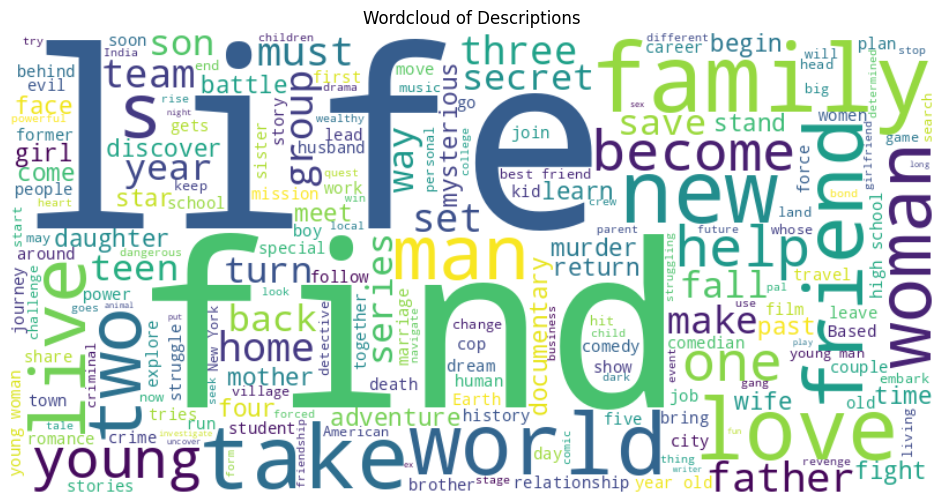

In [9]:
# Wordcloud for description
text = " ".join(df['description'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud of Descriptions")
plt.show()


In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error
)
import numpy as np

# Copy dataset
df_model = df.copy()

# Encode rating
le = LabelEncoder()
df_model['rating_enc'] = le.fit_transform(df_model['rating'])

# Handle missing values
df_model['duration_value'].fillna(df_model['duration_value'].median(), inplace=True)
df_model['year_added'].fillna(df_model['year_added'].median(), inplace=True)

# Features and target
X = df_model[['duration_value', 'rating_enc', 'year_added']]
y = df_model['type'].apply(lambda x: 1 if x == "Movie" else 0)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Predictions
pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, pred)

# Precision
precision = precision_score(y_test, pred, zero_division=0)

# Recall
recall = recall_score(y_test, pred, zero_division=0)

# F1 Score
f1 = f1_score(y_test, pred, zero_division=0)

# RMSE (use predicted probabilities if available)
try:
    pred_prob = model.predict_proba(X_test)[:,1]
except:
    pred_prob = pred.astype(float)

rmse = np.sqrt(mean_squared_error(y_test, pred_prob))

# Print results
print("📊 MODEL PERFORMANCE METRICS")
print("-----------------------------")
print("Accuracy : ", round(accuracy, 4))
print("Precision: ", round(precision, 4))
print("Recall   : ", round(recall, 4))
print("F1 Score : ", round(f1, 4))
print("RMSE     : ", round(rmse, 4))


📊 MODEL PERFORMANCE METRICS
-----------------------------
Accuracy :  0.9989
Precision:  0.9992
Recall   :  0.9992
F1 Score :  0.9992
RMSE     :  0.034


/tmp/ipython-input-3187770925.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model['duration_value'].fillna(df_model['duration_value'].median(), inplace=True)
/tmp/ipython-input-3187770925.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col